<a href="https://colab.research.google.com/github/microprediction/microprediction/blob/master/Nader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests, json
import matplotlib.pyplot as plt

Hi. This notebook scratches a couple of itches I had regarding possible regressors for COVID-19 spread in U.S. counties. I look at density, there the picture seems quite murky, and also at Nader voters. 


---
# *Density*

First we'll grab the county level data from the census. You can also try a pandas.read_csv directly if you like, though you'll have to be careful not to mangle the data and headings. 

In [5]:
census_data = requests.get('https://api.census.gov/data/2019/pep/population?get=DENSITY,POP,NAME&for=county:*').json()
headings = [ h.lower() for h in census_data[0]]
print(headings)
census = pd.DataFrame(columns=headings, data=census_data[1:])
census[:2]

['density', 'pop', 'name', 'state', 'county']


,density,pop,name,state,county
0,1.22086927860000,4198,"Hidalgo County, New Mexico",35,023
1,14555.93898300000000,672391,"Hudson County, New Jersey",34,017


Next we will get some county level census data. Good luck here as the API is a bit wobbly in my experience. 

In [6]:
cases = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
cases[:3]

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0


In [ ]:
len(cases)

337568

Poking around the case cound data a little ...

In [ ]:
cases['county'].value_counts()

Washington     3538
Unknown        3163
Jefferson      2949
Franklin       2782
Jackson        2559
               ... 
Tinian            2
Wibaux            2
Saipan            2
Sanders           2
Sweet Grass       1
Name: county, Length: 1901, dtype: int64

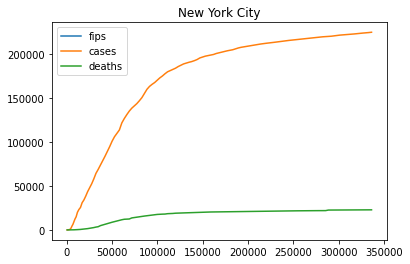

In [ ]:
nyc = cases.loc[cases['county']=='New York City',:]
nyc.plot(title='New York City')


On the other hand...

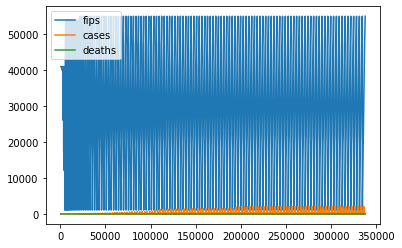

In [ ]:
jackson = cases.loc[cases['county']=='Jackson',:]
jackson.plot()

So we should be a little careful. Let's include state in the name of the county and prepare to join with census data


In [7]:
cases['name'] = [ county+', '+state for county, state in zip(cases['county'].values,cases['state'].values)]
del cases['county']
del cases['state']
sorted_cases = cases[:len(cases)].sort_values(by=['name','date'],inplace=False)
recent_cases = sorted_cases.drop_duplicates(subset=['name'],keep='last')
recent_cases[:5]

,date,fips,cases,deaths,name
796358,2020-12-04,45001.0,1002,22.0,"Abbeville, South Carolina"
795065,2020-12-04,22001.0,4197,118.0,"Acadia, Louisiana"
796868,2020-12-04,51001.0,1367,21.0,"Accomack, Virginia"
794501,2020-12-04,16001.0,27461,264.0,"Ada, Idaho"
794739,2020-12-04,19001.0,472,10.0,"Adair, Iowa"


In [8]:
census['name'] = [ n.replace(' County','').replace(' Parish','') for n in census['name'].values]
merged = recent_cases.merge(census,on=["name"])
merged[:4]

,date,fips,cases,deaths,name,density,pop,state,county
0,2020-12-04,45001.0,1002,22.0,"Abbeville, South Carolina",49.90976045600000,24527,45,001
1,2020-12-04,22001.0,4197,118.0,"Acadia, Louisiana",94.70070754100000,62045,22,001
2,2020-12-04,51001.0,1367,21.0,"Accomack, Virginia",71.92356153100000,32316,51,001
3,2020-12-04,16001.0,27461,264.0,"Ada, Idaho",457.77677936000000,481587,16,001


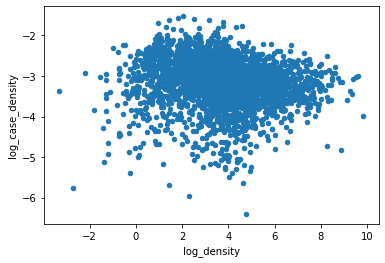

In [9]:
import math 
merged['log_case_density'] = merged['cases'].apply(lambda x: math.log(x)) - merged['pop'].apply(lambda x: math.log(float(x)))
merged['log_density'] = merged['density'].apply(lambda x: math.log(float(x)))
merged.plot.scatter(x='log_density',y='log_case_density')

Okay ... but points are taken at different times along the epidemic curve, so let's look at time since the first case

In [10]:
CASE_MIN = 1  # Case threshold that starts the clock, play with this as you see fit
some_cases = sorted_cases[sorted_cases['cases']>=CASE_MIN]
first_date = some_cases.drop_duplicates(subset=['name'],keep='first').rename(columns={'date':'first_date','cases':'first_day_cases'}).drop(columns=['fips','deaths'])
first_date[:5]
all_merged = some_cases.merge(census,on=["name"]).merge(first_date,on=["name"])
all_merged['days_since_first_case']= pd.to_datetime(all_merged['date'])-pd.to_datetime(all_merged['first_date'])
all_merged['case_ratio'] = all_merged['cases'] / all_merged['first_day_cases']
all_merged['log_case_density'] = all_merged['case_ratio'].apply(lambda x: math.log(x)) - all_merged['pop'].apply(lambda x: math.log(float(x)))
all_merged['log_death_density'] = all_merged['deaths'].apply(lambda x: math.log(float(x)+0.5))
all_merged['log_density'] = all_merged['density'].apply(lambda x: math.log(float(x)))
all_merged[:5]



,date,fips,cases,deaths,name,density,pop,state,county,first_date,first_day_cases,days_since_first_case,case_ratio,log_case_density,log_death_density,log_density
0,2020-03-19,45001.0,1,0.0,"Abbeville, South Carolina",49.90976045600000,24527,45,001,2020-03-19,1,0 days,1.0,-10.10753,-0.693147,3.910217
1,2020-03-20,45001.0,1,0.0,"Abbeville, South Carolina",49.90976045600000,24527,45,001,2020-03-19,1,1 days,1.0,-10.10753,-0.693147,3.910217
2,2020-03-21,45001.0,1,0.0,"Abbeville, South Carolina",49.90976045600000,24527,45,001,2020-03-19,1,2 days,1.0,-10.10753,-0.693147,3.910217
3,2020-03-22,45001.0,1,0.0,"Abbeville, South Carolina",49.90976045600000,24527,45,001,2020-03-19,1,3 days,1.0,-10.10753,-0.693147,3.910217
4,2020-03-23,45001.0,1,0.0,"Abbeville, South Carolina",49.90976045600000,24527,45,001,2020-03-19,1,4 days,1.0,-10.10753,-0.693147,3.910217


We are also going to merge in some voting data to test a hunch. 

---



In [11]:
politics = pd.read_csv('https://raw.githubusercontent.com/microprediction/pandemic/master/empirical/countypres_2000-2016.csv')
politics['name'] = [ county+', '+state for county, state in zip(politics['county'].values,politics['state'].values)]
politics.drop(columns=['state_po','state','county'],inplace=True)
politics = politics.loc[politics['year']==2000,:]
politics[:15]
total_votes = politics[['candidatevotes','name']].groupby(by='name').sum().rename(columns={'candidatevotes':'totalvotes'})
poli  = politics.drop(columns=['totalvotes']).merge(total_votes,on='name')
gore =poli.loc[ poli['candidate']=='Al Gore',:]
gore['log_gore']=(gore['candidatevotes']/gore['totalvotes']).apply(lambda x: math.log(x+0.0001))
gore_voting = gore[['log_gore','year','name']].groupby(by='name').mean().drop(columns=['year'])
nader =poli.loc[ poli['candidate']=='Ralph Nader',:]
nader['log_nader']=(nader['candidatevotes']/nader['totalvotes']).apply(lambda x: math.log(x+0.0001))
nader_voting = nader[['log_nader','year','name']].groupby(by='name').mean().drop(columns=['year'])
bush =poli.loc[ poli['candidate']=='George W. Bush',:]
bush['log_bush']=(bush['candidatevotes']/bush['totalvotes']).apply(lambda x: math.log(x+0.0001))
bush_voting = bush[['log_bush','year','name']].groupby(by='name').mean().drop(columns=['year'])


data = all_merged.merge(nader_voting,on='name').merge(gore_voting,on='name').merge(bush_voting,on='name')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [ ]:
data[:3]

,date,fips,cases,deaths,name,density,pop,state,county,first_date,first_day_cases,days_since_first_case,case_ratio,log_case_density,log_death_density,log_density,log_nader,log_gore,log_bush
0,2020-03-19,45001.0,1,0,"Abbeville, South Carolina",49.909760456,24527,45,001,2020-03-19,1,0 days,1.0,-10.10753,-0.693147,3.910217,-4.830624,-0.798896,-0.632039
1,2020-03-20,45001.0,1,0,"Abbeville, South Carolina",49.909760456,24527,45,001,2020-03-19,1,1 days,1.0,-10.10753,-0.693147,3.910217,-4.830624,-0.798896,-0.632039
2,2020-03-21,45001.0,1,0,"Abbeville, South Carolina",49.909760456,24527,45,001,2020-03-19,1,2 days,1.0,-10.10753,-0.693147,3.910217,-4.830624,-0.798896,-0.632039


Here's a quick look at a few case trajectories. Most counties are still on the upswing 

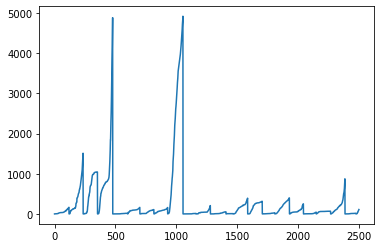

In [ ]:
data['cases'][:2500].plot()

Does population density impact growth if we start the clock when case counts are at CASE_MIN?  This result is pretty surprising. I was led to use a second degree poly to fit it rather than 1. 


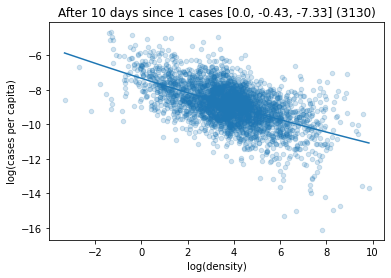

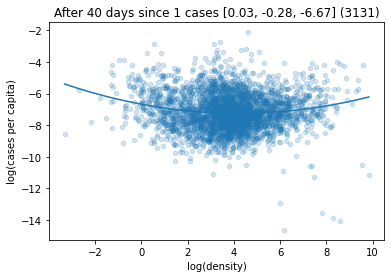

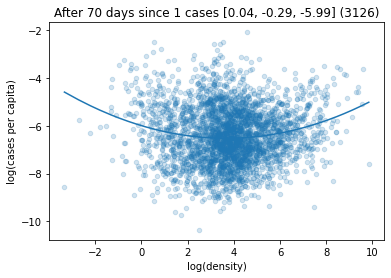

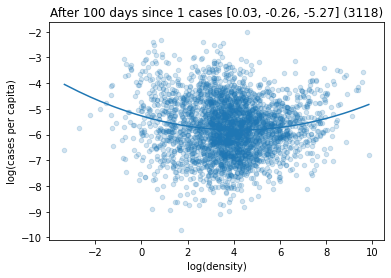

In [12]:
import datetime
import numpy as np
day = datetime.timedelta(days=1)
for k in [10,40,70,100]:
    all_after_k = all_merged.loc[all_merged['days_since_first_case']==k*day,:]
    all_after_k[:10]
    handle = all_after_k.plot.scatter(x='log_density',y='log_case_density',alpha=0.2)
    handle.set_xlabel('log(density)')
    handle.set_ylabel('log(cases per capita)')
    x = all_after_k['log_density'].values
    y = all_after_k['log_case_density'].values
    coef = np.polyfit(x,y,2)
    handle.plot(np.unique(x), np.poly1d(coef)(np.unique(x)))
    handle.set_title('After '+str(k)+' days since '+str(CASE_MIN)+' cases '+str([round(c,2) for c in coef])+' ('+str(round(len(x)))+')')



Did you expect the density smile? 

Me neither. 


---

# *Nader as a safety proxy*

Okay let's test another crazy theory. People who like Ralph Nader like to be safe (you know, because seat belts = masks). 

In [ ]:
data[:4]

,date,fips,cases,deaths,name,density,pop,state,county,first_date,first_day_cases,days_since_first_case,case_ratio,log_case_density,log_death_density,log_density,log_nader,log_gore,log_bush
0,2020-03-19,45001.0,1,0,"Abbeville, South Carolina",49.909760456,24527,45,001,2020-03-19,1,0 days,1.0,-10.10753,-0.693147,3.910217,-4.830624,-0.798896,-0.632039
1,2020-03-20,45001.0,1,0,"Abbeville, South Carolina",49.909760456,24527,45,001,2020-03-19,1,1 days,1.0,-10.10753,-0.693147,3.910217,-4.830624,-0.798896,-0.632039
2,2020-03-21,45001.0,1,0,"Abbeville, South Carolina",49.909760456,24527,45,001,2020-03-19,1,2 days,1.0,-10.10753,-0.693147,3.910217,-4.830624,-0.798896,-0.632039
3,2020-03-22,45001.0,1,0,"Abbeville, South Carolina",49.909760456,24527,45,001,2020-03-19,1,3 days,1.0,-10.10753,-0.693147,3.910217,-4.830624,-0.798896,-0.632039


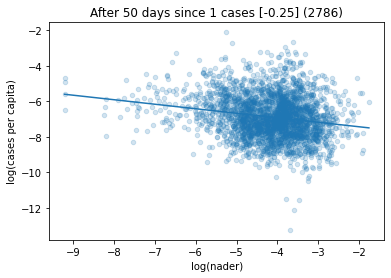

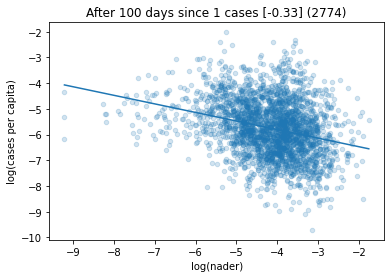

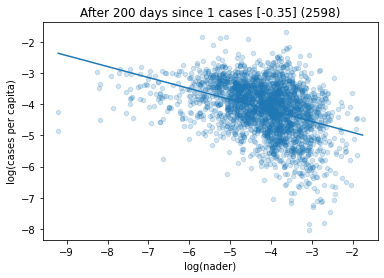

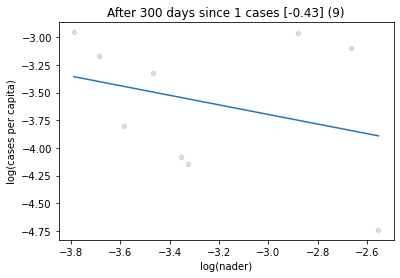

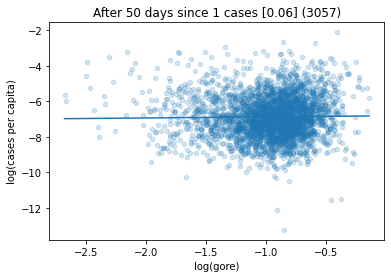

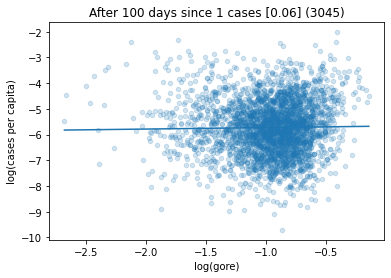

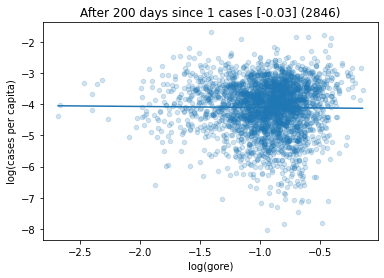

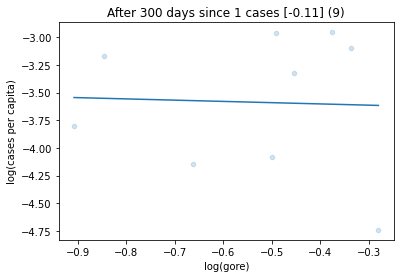

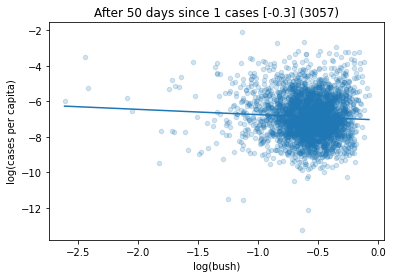

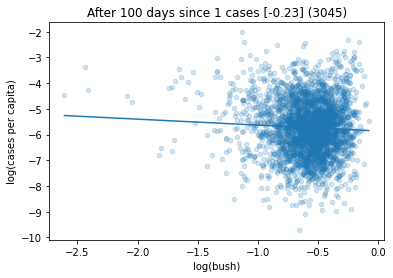

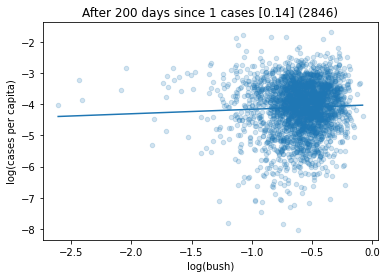

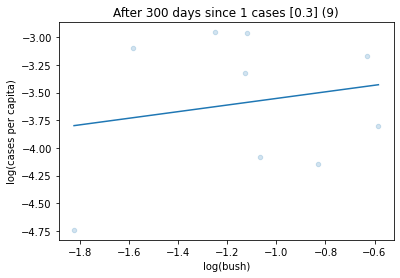

In [14]:
import datetime
import numpy as np
day = datetime.timedelta(days=1)
for candidate in ['nader','gore','bush']:
  regressor = 'log_'+candidate
  clean = data.loc[data[regressor].apply(lambda x: not( np.isnan(x))),: ]
  for k in [50,100,200,300]:
      data_after_k = clean.loc[clean['days_since_first_case']==k*day,:]
      data_after_k[:10]
      handle = data_after_k.plot.scatter(x=regressor,y='log_case_density',alpha=0.2)
      handle.set_xlabel('log('+candidate+')')
      handle.set_ylabel('log(cases per capita)')
      if True:
        x = data_after_k[regressor].values
        y = data_after_k['log_case_density'].values
        coef = np.polyfit(x,y,1)
        handle.plot(np.unique(x), np.poly1d(coef)(np.unique(x)))
        handle.set_title('After '+str(k)+' days since '+str(CASE_MIN)+' cases '+str([round(c,2) for c in coef[:1]])+' ('+str(round(len(x)))+')')
        


Some auxiliary plots for context. 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Number of counties')

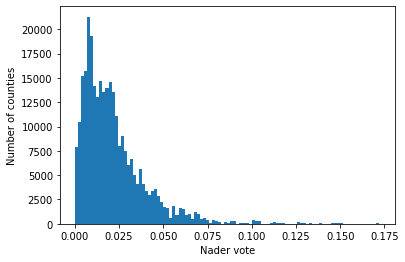

In [ ]:
nd = data['log_nader'].apply(lambda x: math.exp(x)).values
import matplotlib.pyplot as plt
plt.hist(nd,bins=100)
plt.xlabel('Nader vote')
plt.ylabel('Number of counties')

Let's slice up the counties by population to try to compare apples to apples. We look at log of cases and also log of deaths, though the latter is problematic 

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

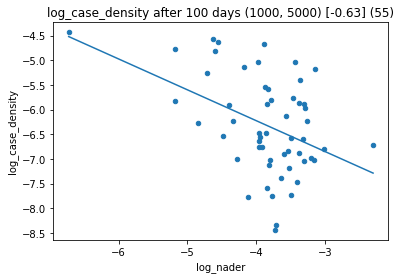

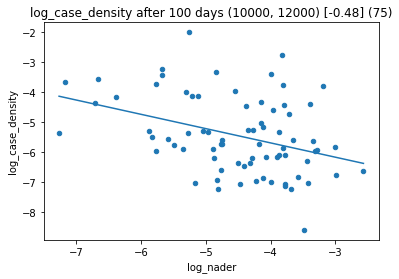

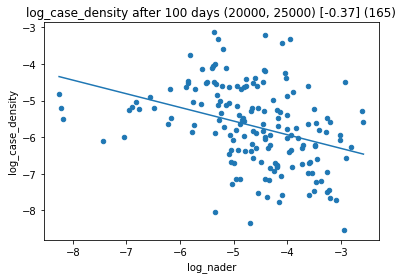

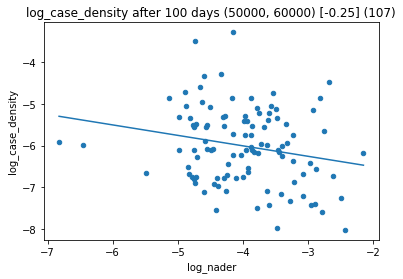

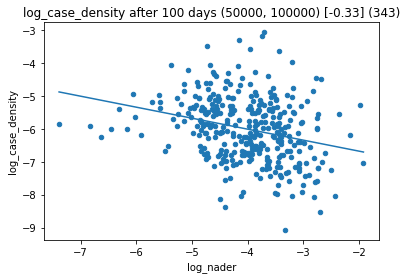

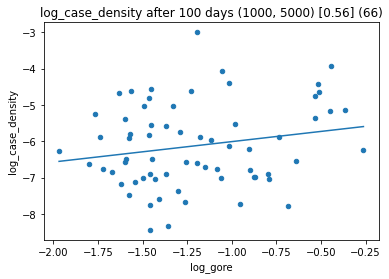

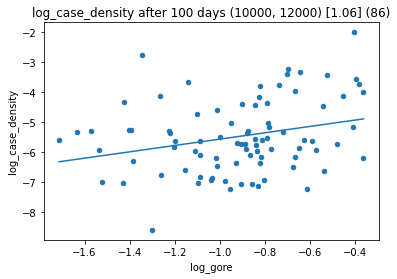

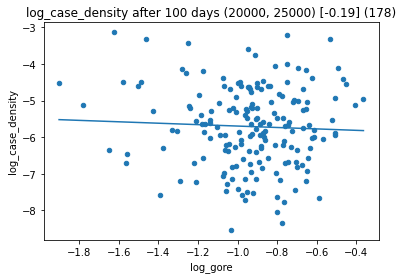

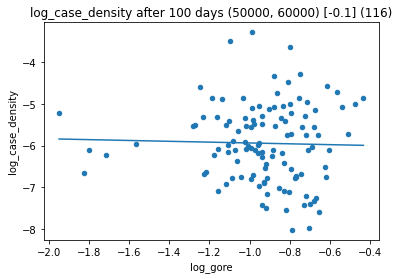

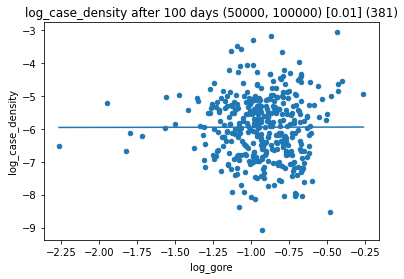

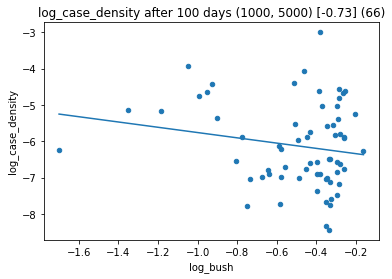

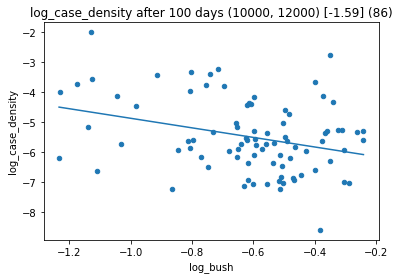

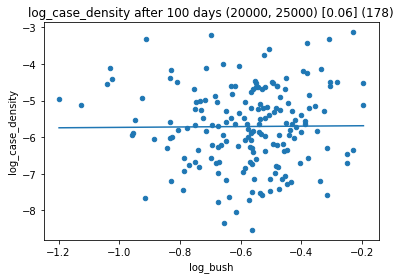

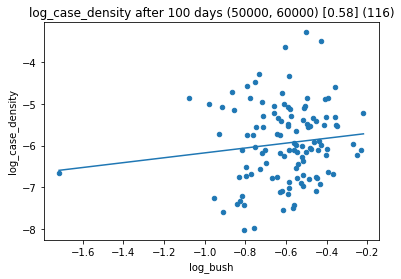

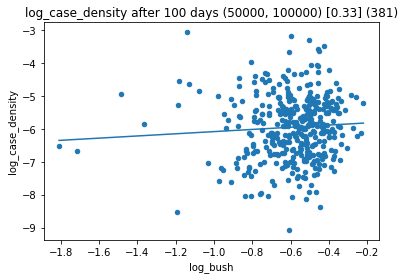

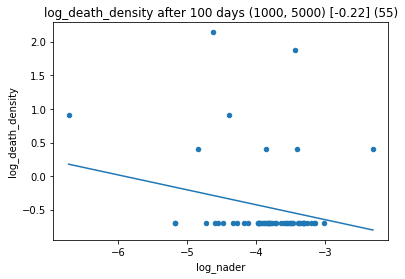

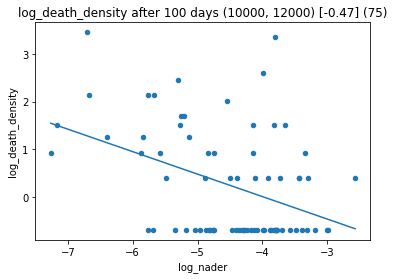

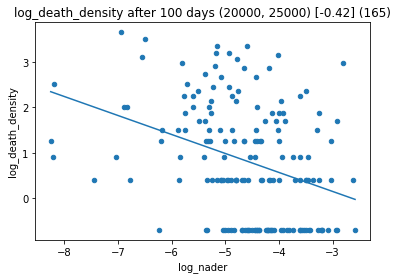

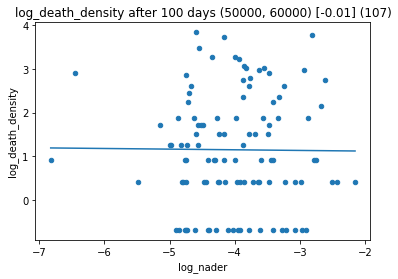

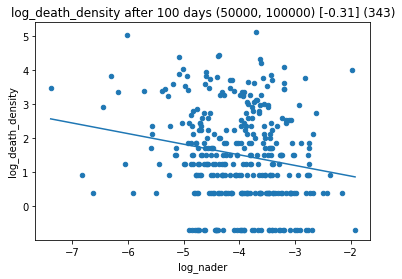

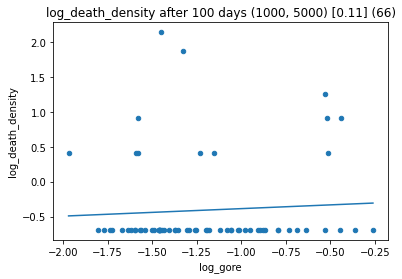

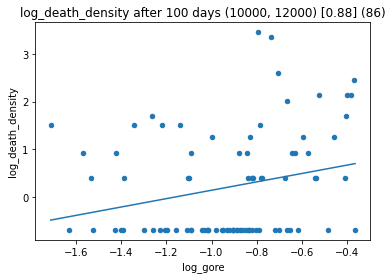

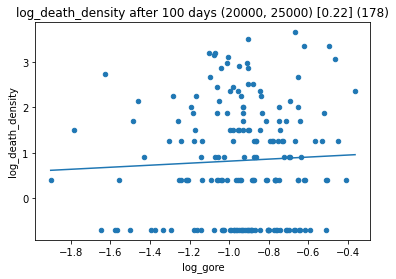

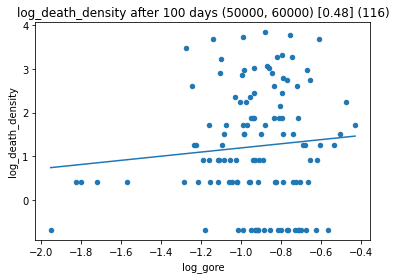

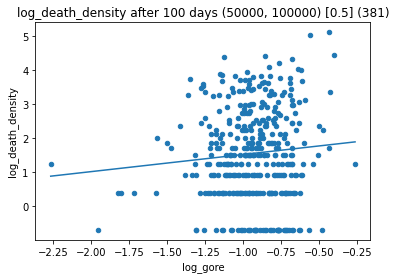

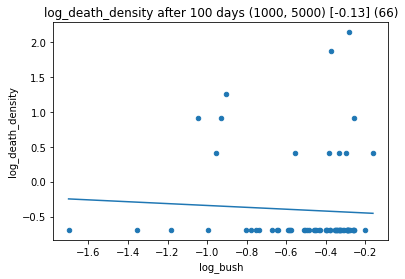

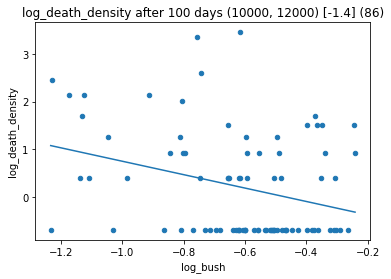

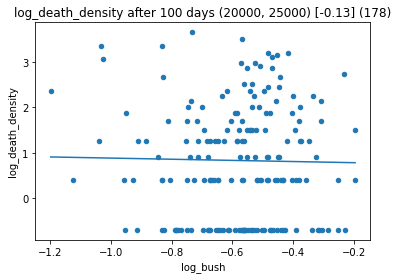

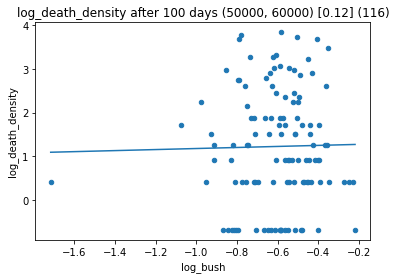

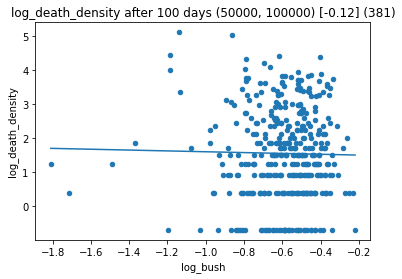

In [ ]:
for regressand in ['log_case_density','log_death_density']:
  for candidate in ['nader','gore','bush']:
    regressor = 'log_'+candidate
    for bounds in [  (1000,5000), (10000,12000),(20000,25000), (50000,60000), (50000,100000) ]:
        cleaner = data.loc[data[regressor].apply(lambda x: not( np.isnan(x))),: ]
        cleaner = cleaner.loc[cleaner['days_since_first_case']==100*day,:].sort_values(by='log_density')
        cleaner = cleaner.loc[cleaner['pop'].apply(lambda x: int(x)>bounds[0] and int(x)<bounds[1]),:]
        handle = cleaner.plot.scatter(x=regressor,y=regressand)
        x = cleaner[regressor]
        y = cleaner[regressand]
        coef = np.polyfit(x,y,1)
        handle.plot(np.unique(x), np.poly1d(coef)(np.unique(x)))
        handle.set_title(regressand+ ' after ' +str(k)+' days '+ str(bounds) +' '+str([round(c,2) for c in coef[:1]])+' ('+str(round(len(x)))+')')





The death data probably should be treated differently. But regardless the outcomes at the top and bottom of the Nader hate/love spectrum are quite stark. 

In [ ]:
cleaner.sort_values(by='log_nader')

,date,fips,cases,deaths,name,density,pop,state,county,first_date,first_day_cases,days_since_first_case,case_ratio,log_case_density,log_density,log_nader,log_gore,log_bush
237681,2020-07-02,13235.0,51,2,"Pulaski, Georgia",44.680007989,11137,13,235,2020-03-24,1,100 days,51.0,-5.386203,3.799526,-7.267680,-0.878221,-0.554225
11770,2020-07-07,13005.0,283,4,"Bacon, Georgia",39.29810477,11164,13,005,2020-03-29,1,100 days,283.0,-3.675003,3.671176,-7.172008,-1.141628,-0.398661
85084,2020-06-27,13099.0,260,31,"Early, Georgia",19.879066674,10190,13,099,2020-03-19,2,100 days,130.0,-4.361628,2.989667,-6.712386,-0.792878,-0.614917
308883,2020-07-03,1131.0,291,8,"Wilcox, Alabama",11.675388474,10373,01,131,2020-03-25,1,100 days,291.0,-3.573638,2.457483,-6.668342,-0.397543,-1.126597
159323,2020-07-10,13173.0,163,3,"Lanier, Georgia",53.033498688,10423,13,173,2020-04-01,1,100 days,163.0,-4.158020,3.970924,-6.391566,-0.827651,-0.596892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21922,2020-07-03,48031.0,31,1,"Blanco, Texas",16.821952593,11931,48,031,2020-03-25,1,100 days,31.0,-5.952908,2.822685,-3.289705,-1.535302,-0.304772
302453,2020-07-08,27165.0,240,0,"Watonwan, Minnesota",25.053207396,10897,27,165,2020-03-30,1,100 days,240.0,-3.815604,3.221002,-3.184635,-0.821178,-0.694897
38623,2020-07-10,30009.0,31,0,"Carbon, Montana",5.2375714543,10725,30,009,2020-04-01,1,100 days,31.0,-5.846346,1.655858,-3.003998,-1.205520,-0.464887
290940,2020-06-30,16085.0,13,0,"Valley, Idaho",3.1082233059,11392,16,085,2020-03-22,1,100 days,13.0,-6.775717,1.134051,-2.983252,-1.259095,-0.445314


In [ ]:
sparse100[-200:-100].describe()

,fips,cases,deaths,first_day_cases,days_since_first_case,case_ratio,log_case_density,log_density,log_nader,log_gore,log_bush
count,100.00000,100.000000,100.000000,100.000000,100,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,28453.33000,138.700000,5.850000,1.170000,100 days 00:00:00,127.820000,-6.324472,2.124067,-3.596160,-1.140818,-0.498133
std,12576.05009,437.707215,24.889402,0.427702,0 days 00:00:00,424.359794,1.148449,0.899253,0.132017,0.319240,0.187700
min,4003.00000,1.000000,0.000000,1.000000,100 days 00:00:00,1.000000,-8.881697,-0.674573,-3.816385,-1.950860,-1.241278
25%,20070.50000,9.000000,0.000000,1.000000,100 days 00:00:00,7.750000,-7.129037,1.518049,-3.707657,-1.359212,-0.594192
50%,30093.00000,24.000000,0.000000,1.000000,100 days 00:00:00,20.000000,-6.402955,2.387906,-3.589057,-1.143709,-0.473569
75%,38028.00000,78.750000,2.000000,1.000000,100 days 00:00:00,53.250000,-5.643393,2.881423,-3.477383,-0.910885,-0.355722
max,53075.00000,3336.000000,166.000000,3.000000,100 days 00:00:00,3336.000000,-3.063063,3.176578,-3.386084,-0.392463,-0.219967
